In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from matplotlib import pyplot as plt

In [31]:
class HVAE(nn.Module):

    def __init__(self, input_dim, hidden_dim, z1_dim, z2_dim):
        super(HVAE, self).__init__()
        
        # First Encoder (q(z1 | x))
        self.e1_fc1 = nn.Linear(input_dim, hidden_dim)
        self.e1_fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.e1_fc_mu = nn.Linear(hidden_dim, z1_dim)
        self.e1_fc_logvar = nn.Linear(hidden_dim, z1_dim)
        
        # Second Encoder (q(z2 | z1))
        self.e2_fc1 = nn.Linear(z1_dim, hidden_dim)
        self.e2_fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.e2_fc_mu = nn.Linear(hidden_dim, z2_dim)
        self.e2_fc_logvar = nn.Linear(hidden_dim, z2_dim)
        
        # First Decoder (p(z1 | z2))
        self.d1_fc1 = nn.Linear(z2_dim, hidden_dim)
        self.d1_fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.d1_fc_mu = nn.Linear(hidden_dim, z1_dim)
        self.d1_fc_logvar = nn.Linear(hidden_dim, z1_dim)
        
        # Second Decoder (p(x | z1))
        self.d2_fc1 = nn.Linear(z1_dim, hidden_dim)
        self.d2_fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.d2_fc_out = nn.Linear(hidden_dim, input_dim)
        
    def encode_z1(self, x):
        x = torch.relu(self.e1_fc1(x))
        x = torch.relu(self.e1_fc2(x))
        mu = self.e1_fc_mu(x)
        logvar = self.e1_fc_logvar(x)
        return mu, logvar
    
    def encode_z2(self, x):
        x = torch.relu(self.e2_fc1(x))
        x = torch.relu(self.e2_fc2(x))
        mu = self.e2_fc_mu(x)
        logvar = self.e2_fc_logvar(x)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode_z1(self, x):
        x = torch.relu(self.d1_fc1(x))
        x = torch.relu(self.d1_fc2(x))
        mu = self.d1_fc_mu(x)
        logvar = self.d1_fc_logvar(x)
        return mu, logvar
    
    def decode_x(self, x):
        x = torch.relu(self.d2_fc1(x))
        x = torch.relu(self.d2_fc2(x))
        return torch.sigmoid(self.d2_fc_out(x))
    
    # def forward(self, x):
    #     # Encode x to z1
    #     mu_z1, logvar_z1 = self.encode_z1(x)
    #     z1 = self.reparameterize(mu_z1, logvar_z1)
        
    #     # Encode z1 to z2
    #     mu_z2, logvar_z2 = self.encode_z2(z1)
    #     z2 = self.reparameterize(mu_z2, logvar_z2)
        
    #     # Decode z2 to z1
    #     mu_z1_dec, logvar_z1_dec = self.decode_z1(z2)
    #     z1_dec = self.reparameterize(mu_z1_dec, logvar_z1_dec)
        
    #     # Decode z1 to x
    #     recon_x = self.decode_x(z1_dec)
        
    #     return recon_x, mu_z1, logvar_z1, mu_z2, logvar_z2, mu_z1_dec, logvar_z1_dec

    def forward(self, x):
        # Encode x to z1
        mu_z1, logvar_z1 = self.encode_z1(x)
        z1 = self.reparameterize(mu_z1, logvar_z1)
        
        # # Encode z1 to z2
        # mu_z2, logvar_z2 = self.encode_z2(z1)
        # z2 = self.reparameterize(mu_z2, logvar_z2)
        
        # # Decode z2 to z1
        # mu_z1_dec, logvar_z1_dec = self.decode_z1(z2)
        # z1_dec = self.reparameterize(mu_z1_dec, logvar_z1_dec)
        
        # Decode z1 to x
        # recon_x = self.decode_x(z1_dec)
        recon_x = self.decode_x(z1)
        
        # return recon_x, mu_z1, logvar_z1, mu_z2, logvar_z2, mu_z1_dec, logvar_z1_dec
        return recon_x, mu_z1, logvar_z1
    

# def loss_function(recon_x, x, mu_z1, logvar_z1, mu_z2, logvar_z2, mu_z1_dec, logvar_z1_dec):
#     # Reconstruction loss
#     BCE = nn.functional.binary_cross_entropy(recon_x, x.view(x.size(0), -1), reduction='sum')
    
#     # KL divergence for z1
#     KLD_z1 = -0.5 * torch.sum(1 + logvar_z1 - mu_z1.pow(2) - logvar_z1.exp())
    
#     # KL divergence for z2
#     KLD_z2 = -0.5 * torch.sum(1 + logvar_z2 - mu_z2.pow(2) - logvar_z2.exp())
    
#     # KL divergence for p(z1 | z2)
#     KLD_z1_dec = -0.5 * torch.sum(1 + logvar_z1_dec - mu_z1_dec.pow(2) - logvar_z1_dec.exp())
    
#     return BCE + KLD_z1 + KLD_z2 + KLD_z1_dec

def loss_function(recon_x, x, mu_z1, logvar_z1):
    # Reconstruction loss
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(x.size(0), -1), reduction='sum')
    
    # # KL divergence for z1
    # KLD_z1 = -0.5 * torch.sum(1 + logvar_z1 - mu_z1.pow(2) - logvar_z1.exp())
    
    # # KL divergence for z2
    # KLD_z2 = -0.5 * torch.sum(1 + logvar_z2 - mu_z2.pow(2) - logvar_z2.exp())
    
    # KL divergence for p(z1 | z2)
    # KLD_z1_dec = -0.5 * torch.sum(1 + logvar_z1_dec - mu_z1_dec.pow(2) - logvar_z1_dec.exp())
    KLD_z1_dec = -0.5 * torch.sum(1 + logvar_z1 - mu_z1.pow(2) - logvar_z1.exp())
    
    # return BCE + KLD_z1 + KLD_z2 + KLD_z1_dec
    return BCE + KLD_z1_dec


# def train(model, train_loader, optimizer, epoch):
#     model.train()
#     train_loss = 0
#     for batch_idx, (data, _) in enumerate(train_loader):
#         data = data.view(data.size(0), -1)
#         optimizer.zero_grad()
#         recon_batch, mu_z1, logvar_z1, mu_z2, logvar_z2, mu_z1_dec, logvar_z1_dec = model(data)
#         loss = loss_function(recon_batch, data, mu_z1, logvar_z1, mu_z2, logvar_z2, mu_z1_dec, logvar_z1_dec)
#         loss.backward()
#         train_loss += loss.item()
#         optimizer.step()
        
#         if batch_idx % 100 == 0:
#             print(f'Epoch {epoch}, Batch {batch_idx}, Loss {loss.item() / len(data):.6f}')
    
#     print(f'====> Epoch {epoch} Average loss: {train_loss / len(train_loader.dataset):.4f}')


def train(model, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.view(data.size(0), -1)
        optimizer.zero_grad()
        # recon_batch, mu_z1, logvar_z1, mu_z2, logvar_z2, mu_z1_dec, logvar_z1_dec = model(data)
        recon_batch, mu_z1, logvar_z1 = model(data)
        # loss = loss_function(recon_batch, data, mu_z1, logvar_z1, mu_z2, logvar_z2, mu_z1_dec, logvar_z1_dec)
        loss = loss_function(recon_batch, data, mu_z1, logvar_z1)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print(f'Epoch {epoch}, Batch {batch_idx}, Loss {loss.item() / len(data):.6f}')
    
    print(f'====> Epoch {epoch} Average loss: {train_loss / len(train_loader.dataset):.4f}')


In [83]:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Grayscale()
])
train_loader = DataLoader(
    datasets.CelebA('../data', download=True, 
                    transform=transform),
    batch_size=batch_size, shuffle=True)

Files already downloaded and verified


In [32]:
# Hyperparameters
batch_size = 128
input_dim  = 784
hidden_dim = 512
z1_dim = 256
z2_dim = 128
epochs = 200
learning_rate = 1e-3

# Data loading
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Grayscale()
])
train_loader = DataLoader(
    datasets.MNIST('../data', train=True, download=True, 
                    transform=transform),
    batch_size=batch_size, shuffle=True)

# Model, optimizer
model = HVAE(input_dim=input_dim, hidden_dim=hidden_dim, z1_dim=z1_dim, z2_dim=z2_dim)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

# Training
for epoch in range(1, epochs + 1):
    train(model, train_loader, optimizer, epoch)


Epoch 1, Batch 0, Loss 543.547607
Epoch 1, Batch 100, Loss 200.759277
Epoch 1, Batch 200, Loss 183.188370
Epoch 1, Batch 300, Loss 174.097748
Epoch 1, Batch 400, Loss 158.435394
====> Epoch 1 Average loss: 186.8992
Epoch 2, Batch 0, Loss 154.981644
Epoch 2, Batch 100, Loss 153.991196
Epoch 2, Batch 200, Loss 150.128845
Epoch 2, Batch 300, Loss 141.944656
Epoch 2, Batch 400, Loss 140.798309
====> Epoch 2 Average loss: 146.7217
Epoch 3, Batch 0, Loss 143.802765
Epoch 3, Batch 100, Loss 130.242065
Epoch 3, Batch 200, Loss 123.623161
Epoch 3, Batch 300, Loss 124.204102
Epoch 3, Batch 400, Loss 120.491562
====> Epoch 3 Average loss: 128.1443
Epoch 4, Batch 0, Loss 129.146133
Epoch 4, Batch 100, Loss 118.330139
Epoch 4, Batch 200, Loss 116.656929
Epoch 4, Batch 300, Loss 116.649696
Epoch 4, Batch 400, Loss 117.369095
====> Epoch 4 Average loss: 118.9075
Epoch 5, Batch 0, Loss 116.158661
Epoch 5, Batch 100, Loss 114.048744
Epoch 5, Batch 200, Loss 115.207306
Epoch 5, Batch 300, Loss 111.92704

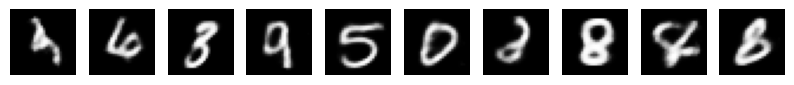

In [33]:
plot_size = 10

model.eval()
with torch.no_grad():
    z2 = torch.randn(plot_size, z2_dim)
    mu_z1_dec, logvar_z1_dec = model.decode_z1(z2)
    z1 = model.reparameterize(mu_z1_dec, logvar_z1_dec)
    gen_x = model.decode_x(z1)

fig, axes = plt.subplots(nrows=1, ncols=plot_size, figsize=(10, 4))
for idx in range(plot_size):
    axes[idx].imshow(gen_x[idx].reshape(28, 28), cmap='gray')
    axes[idx].axis('off')
plt.show()

In [34]:
log = """
Epoch 1, Batch 0, Loss 543.547607
Epoch 1, Batch 100, Loss 200.759277
Epoch 1, Batch 200, Loss 183.188370
Epoch 1, Batch 300, Loss 174.097748
Epoch 1, Batch 400, Loss 158.435394
====> Epoch 1 Average loss: 186.8992
Epoch 2, Batch 0, Loss 154.981644
Epoch 2, Batch 100, Loss 153.991196
Epoch 2, Batch 200, Loss 150.128845
Epoch 2, Batch 300, Loss 141.944656
Epoch 2, Batch 400, Loss 140.798309
====> Epoch 2 Average loss: 146.7217
Epoch 3, Batch 0, Loss 143.802765
Epoch 3, Batch 100, Loss 130.242065
Epoch 3, Batch 200, Loss 123.623161
Epoch 3, Batch 300, Loss 124.204102
Epoch 3, Batch 400, Loss 120.491562
====> Epoch 3 Average loss: 128.1443
Epoch 4, Batch 0, Loss 129.146133
Epoch 4, Batch 100, Loss 118.330139
Epoch 4, Batch 200, Loss 116.656929
Epoch 4, Batch 300, Loss 116.649696
Epoch 4, Batch 400, Loss 117.369095
====> Epoch 4 Average loss: 118.9075
Epoch 5, Batch 0, Loss 116.158661
Epoch 5, Batch 100, Loss 114.048744
Epoch 5, Batch 200, Loss 115.207306
Epoch 5, Batch 300, Loss 111.927040
Epoch 5, Batch 400, Loss 112.318794
====> Epoch 5 Average loss: 113.7934
Epoch 6, Batch 0, Loss 113.617569
Epoch 6, Batch 100, Loss 106.008240
Epoch 6, Batch 200, Loss 111.353745
Epoch 6, Batch 300, Loss 112.988541
Epoch 6, Batch 400, Loss 110.555664
====> Epoch 6 Average loss: 111.2519
Epoch 7, Batch 0, Loss 108.949440
Epoch 7, Batch 100, Loss 108.506310
Epoch 7, Batch 200, Loss 112.329124
Epoch 7, Batch 300, Loss 110.276382
Epoch 7, Batch 400, Loss 104.823639
====> Epoch 7 Average loss: 109.4987
Epoch 8, Batch 0, Loss 109.682922
Epoch 8, Batch 100, Loss 105.976822
Epoch 8, Batch 200, Loss 104.827728
Epoch 8, Batch 300, Loss 104.897514
Epoch 8, Batch 400, Loss 108.516060
====> Epoch 8 Average loss: 108.3315
Epoch 9, Batch 0, Loss 108.863556
Epoch 9, Batch 100, Loss 105.741783
Epoch 9, Batch 200, Loss 107.947037
Epoch 9, Batch 300, Loss 105.026733
Epoch 9, Batch 400, Loss 104.999474
====> Epoch 9 Average loss: 107.3795
Epoch 10, Batch 0, Loss 106.758118
Epoch 10, Batch 100, Loss 102.404732
Epoch 10, Batch 200, Loss 103.741447
Epoch 10, Batch 300, Loss 104.335777
Epoch 10, Batch 400, Loss 106.478851
====> Epoch 10 Average loss: 106.5874
Epoch 11, Batch 0, Loss 101.734848
Epoch 11, Batch 100, Loss 106.094505
Epoch 11, Batch 200, Loss 108.261688
Epoch 11, Batch 300, Loss 103.133568
Epoch 11, Batch 400, Loss 110.578522
====> Epoch 11 Average loss: 105.7196
Epoch 12, Batch 0, Loss 109.991463
Epoch 12, Batch 100, Loss 105.537949
Epoch 12, Batch 200, Loss 106.275558
Epoch 12, Batch 300, Loss 99.426682
Epoch 12, Batch 400, Loss 104.532478
====> Epoch 12 Average loss: 104.8773
Epoch 13, Batch 0, Loss 110.460823
Epoch 13, Batch 100, Loss 100.695038
Epoch 13, Batch 200, Loss 99.558548
Epoch 13, Batch 300, Loss 107.786201
Epoch 13, Batch 400, Loss 104.987167
====> Epoch 13 Average loss: 104.3742
Epoch 14, Batch 0, Loss 103.596664
Epoch 14, Batch 100, Loss 104.036682
Epoch 14, Batch 200, Loss 101.521713
Epoch 14, Batch 300, Loss 105.920990
Epoch 14, Batch 400, Loss 101.842667
====> Epoch 14 Average loss: 103.9812
Epoch 15, Batch 0, Loss 102.746162
Epoch 15, Batch 100, Loss 105.038513
Epoch 15, Batch 200, Loss 99.045273
Epoch 15, Batch 300, Loss 101.360641
Epoch 15, Batch 400, Loss 104.228050
====> Epoch 15 Average loss: 103.5679
Epoch 16, Batch 0, Loss 106.903587
Epoch 16, Batch 100, Loss 103.620438
Epoch 16, Batch 200, Loss 104.236816
Epoch 16, Batch 300, Loss 104.630386
Epoch 16, Batch 400, Loss 104.110229
====> Epoch 16 Average loss: 103.2263
Epoch 17, Batch 0, Loss 106.345840
Epoch 17, Batch 100, Loss 101.753471
Epoch 17, Batch 200, Loss 99.610168
Epoch 17, Batch 300, Loss 102.387939
Epoch 17, Batch 400, Loss 105.214058
====> Epoch 17 Average loss: 102.8811
Epoch 18, Batch 0, Loss 102.332451
Epoch 18, Batch 100, Loss 103.479828
Epoch 18, Batch 200, Loss 99.663406
Epoch 18, Batch 300, Loss 104.315887
Epoch 18, Batch 400, Loss 106.703125
====> Epoch 18 Average loss: 102.6638
Epoch 19, Batch 0, Loss 99.803650
Epoch 19, Batch 100, Loss 101.219322
Epoch 19, Batch 200, Loss 104.279182
Epoch 19, Batch 300, Loss 104.647690
Epoch 19, Batch 400, Loss 99.927361
====> Epoch 19 Average loss: 102.3924
Epoch 20, Batch 0, Loss 100.485161
Epoch 20, Batch 100, Loss 100.669083
Epoch 20, Batch 200, Loss 101.886375
Epoch 20, Batch 300, Loss 98.304337
Epoch 20, Batch 400, Loss 103.596436
====> Epoch 20 Average loss: 101.9913
Epoch 21, Batch 0, Loss 102.750473
Epoch 21, Batch 100, Loss 106.238693
Epoch 21, Batch 200, Loss 100.656067
Epoch 21, Batch 300, Loss 100.271347
Epoch 21, Batch 400, Loss 104.739517
====> Epoch 21 Average loss: 101.7530
Epoch 22, Batch 0, Loss 101.596931
Epoch 22, Batch 100, Loss 99.276505
Epoch 22, Batch 200, Loss 104.995880
Epoch 22, Batch 300, Loss 104.220131
Epoch 22, Batch 400, Loss 102.022842
====> Epoch 22 Average loss: 101.4369
Epoch 23, Batch 0, Loss 98.807266
Epoch 23, Batch 100, Loss 99.702896
Epoch 23, Batch 200, Loss 99.409317
Epoch 23, Batch 300, Loss 102.568428
Epoch 23, Batch 400, Loss 100.249969
====> Epoch 23 Average loss: 101.2001
Epoch 24, Batch 0, Loss 98.006302
Epoch 24, Batch 100, Loss 99.825386
Epoch 24, Batch 200, Loss 103.529213
Epoch 24, Batch 300, Loss 100.456612
Epoch 24, Batch 400, Loss 97.243782
====> Epoch 24 Average loss: 101.0939
Epoch 25, Batch 0, Loss 95.852257
Epoch 25, Batch 100, Loss 99.511154
Epoch 25, Batch 200, Loss 101.637115
Epoch 25, Batch 300, Loss 100.100647
Epoch 25, Batch 400, Loss 104.303391
====> Epoch 25 Average loss: 100.8783
Epoch 26, Batch 0, Loss 100.962311
Epoch 26, Batch 100, Loss 98.581291
Epoch 26, Batch 200, Loss 100.319313
Epoch 26, Batch 300, Loss 98.792969
Epoch 26, Batch 400, Loss 99.016663
====> Epoch 26 Average loss: 100.6485
Epoch 27, Batch 0, Loss 99.329376
Epoch 27, Batch 100, Loss 101.407295
Epoch 27, Batch 200, Loss 97.689743
Epoch 27, Batch 300, Loss 100.244156
Epoch 27, Batch 400, Loss 104.521782
====> Epoch 27 Average loss: 100.5999
Epoch 28, Batch 0, Loss 97.943726
Epoch 28, Batch 100, Loss 102.897301
Epoch 28, Batch 200, Loss 103.236252
Epoch 28, Batch 300, Loss 98.896881
Epoch 28, Batch 400, Loss 101.186920
====> Epoch 28 Average loss: 100.4406
Epoch 29, Batch 0, Loss 99.962051
Epoch 29, Batch 100, Loss 100.918221
Epoch 29, Batch 200, Loss 101.685303
Epoch 29, Batch 300, Loss 98.329300
Epoch 29, Batch 400, Loss 102.572533
====> Epoch 29 Average loss: 100.3077
Epoch 30, Batch 0, Loss 99.736801
Epoch 30, Batch 100, Loss 99.687057
Epoch 30, Batch 200, Loss 98.713318
Epoch 30, Batch 300, Loss 99.444824
Epoch 30, Batch 400, Loss 100.213936
====> Epoch 30 Average loss: 100.1972
Epoch 31, Batch 0, Loss 106.034653
Epoch 31, Batch 100, Loss 96.214081
Epoch 31, Batch 200, Loss 99.805260
Epoch 31, Batch 300, Loss 103.848244
Epoch 31, Batch 400, Loss 99.077492
====> Epoch 31 Average loss: 100.0823
Epoch 32, Batch 0, Loss 96.903732
Epoch 32, Batch 100, Loss 100.423615
Epoch 32, Batch 200, Loss 101.817772
Epoch 32, Batch 300, Loss 99.186035
Epoch 32, Batch 400, Loss 100.834045
====> Epoch 32 Average loss: 99.9373
Epoch 33, Batch 0, Loss 100.959702
Epoch 33, Batch 100, Loss 103.477722
Epoch 33, Batch 200, Loss 98.910233
Epoch 33, Batch 300, Loss 98.964249
Epoch 33, Batch 400, Loss 100.580948
====> Epoch 33 Average loss: 99.8247
Epoch 34, Batch 0, Loss 99.820862
Epoch 34, Batch 100, Loss 99.006905
Epoch 34, Batch 200, Loss 100.014526
Epoch 34, Batch 300, Loss 97.082169
Epoch 34, Batch 400, Loss 97.918030
====> Epoch 34 Average loss: 99.6794
Epoch 35, Batch 0, Loss 98.861923
Epoch 35, Batch 100, Loss 102.023132
Epoch 35, Batch 200, Loss 102.800934
Epoch 35, Batch 300, Loss 99.324997
Epoch 35, Batch 400, Loss 100.123444
====> Epoch 35 Average loss: 99.6441
Epoch 36, Batch 0, Loss 96.813133
Epoch 36, Batch 100, Loss 101.529526
Epoch 36, Batch 200, Loss 99.029869
Epoch 36, Batch 300, Loss 100.989799
Epoch 36, Batch 400, Loss 100.573433
====> Epoch 36 Average loss: 99.6042
Epoch 37, Batch 0, Loss 94.994186
Epoch 37, Batch 100, Loss 96.370430
Epoch 37, Batch 200, Loss 97.376907
Epoch 37, Batch 300, Loss 102.132103
Epoch 37, Batch 400, Loss 102.456345
====> Epoch 37 Average loss: 99.4830
Epoch 38, Batch 0, Loss 100.317177
Epoch 38, Batch 100, Loss 100.051208
Epoch 38, Batch 200, Loss 99.866913
Epoch 38, Batch 300, Loss 99.945709
Epoch 38, Batch 400, Loss 98.260132
====> Epoch 38 Average loss: 99.4126
Epoch 39, Batch 0, Loss 99.032951
Epoch 39, Batch 100, Loss 99.208710
Epoch 39, Batch 200, Loss 98.606300
Epoch 39, Batch 300, Loss 100.621704
Epoch 39, Batch 400, Loss 99.247726
====> Epoch 39 Average loss: 99.3440
Epoch 40, Batch 0, Loss 101.100464
Epoch 40, Batch 100, Loss 97.913925
Epoch 40, Batch 200, Loss 100.120811
Epoch 40, Batch 300, Loss 101.931152
Epoch 40, Batch 400, Loss 98.191895
====> Epoch 40 Average loss: 99.1829
Epoch 41, Batch 0, Loss 102.022972
Epoch 41, Batch 100, Loss 99.536751
Epoch 41, Batch 200, Loss 100.649147
Epoch 41, Batch 300, Loss 98.840668
Epoch 41, Batch 400, Loss 99.878784
====> Epoch 41 Average loss: 99.1876
Epoch 42, Batch 0, Loss 100.331474
Epoch 42, Batch 100, Loss 96.528206
Epoch 42, Batch 200, Loss 99.615837
Epoch 42, Batch 300, Loss 96.659035
Epoch 42, Batch 400, Loss 99.469185
====> Epoch 42 Average loss: 99.0982
Epoch 43, Batch 0, Loss 96.912041
Epoch 43, Batch 100, Loss 99.166283
Epoch 43, Batch 200, Loss 102.121254
Epoch 43, Batch 300, Loss 104.742844
Epoch 43, Batch 400, Loss 100.310005
====> Epoch 43 Average loss: 99.0061
Epoch 44, Batch 0, Loss 98.161545
Epoch 44, Batch 100, Loss 100.308853
Epoch 44, Batch 200, Loss 101.528114
Epoch 44, Batch 300, Loss 99.019119
Epoch 44, Batch 400, Loss 97.937302
====> Epoch 44 Average loss: 98.9629
Epoch 45, Batch 0, Loss 98.516464
Epoch 45, Batch 100, Loss 99.266487
Epoch 45, Batch 200, Loss 98.691154
Epoch 45, Batch 300, Loss 106.046410
Epoch 45, Batch 400, Loss 96.517395
====> Epoch 45 Average loss: 98.8446
Epoch 46, Batch 0, Loss 101.493683
Epoch 46, Batch 100, Loss 96.825958
Epoch 46, Batch 200, Loss 95.895752
Epoch 46, Batch 300, Loss 102.287193
Epoch 46, Batch 400, Loss 99.529167
====> Epoch 46 Average loss: 98.7670
Epoch 47, Batch 0, Loss 100.374748
Epoch 47, Batch 100, Loss 101.656578
Epoch 47, Batch 200, Loss 100.496384
Epoch 47, Batch 300, Loss 98.394424
Epoch 47, Batch 400, Loss 99.109978
====> Epoch 47 Average loss: 98.7285
Epoch 48, Batch 0, Loss 102.922363
Epoch 48, Batch 100, Loss 99.732018
Epoch 48, Batch 200, Loss 98.647964
Epoch 48, Batch 300, Loss 99.990875
Epoch 48, Batch 400, Loss 97.957214
====> Epoch 48 Average loss: 98.6530
Epoch 49, Batch 0, Loss 94.070442
Epoch 49, Batch 100, Loss 99.038635
Epoch 49, Batch 200, Loss 101.709747
Epoch 49, Batch 300, Loss 97.134041
Epoch 49, Batch 400, Loss 95.813461
====> Epoch 49 Average loss: 98.6251
Epoch 50, Batch 0, Loss 93.040848
Epoch 50, Batch 100, Loss 97.278656
Epoch 50, Batch 200, Loss 91.077744
Epoch 50, Batch 300, Loss 97.315292
Epoch 50, Batch 400, Loss 97.825363
====> Epoch 50 Average loss: 98.5804
Epoch 51, Batch 0, Loss 98.220169
Epoch 51, Batch 100, Loss 98.089157
Epoch 51, Batch 200, Loss 98.749191
Epoch 51, Batch 300, Loss 99.589348
Epoch 51, Batch 400, Loss 95.425255
====> Epoch 51 Average loss: 98.4278
Epoch 52, Batch 0, Loss 100.800735
Epoch 52, Batch 100, Loss 99.175087
Epoch 52, Batch 200, Loss 97.373024
Epoch 52, Batch 300, Loss 102.045364
Epoch 52, Batch 400, Loss 102.572899
====> Epoch 52 Average loss: 98.3987
Epoch 53, Batch 0, Loss 101.002914
Epoch 53, Batch 100, Loss 99.218788
Epoch 53, Batch 200, Loss 97.021530
Epoch 53, Batch 300, Loss 95.688858
Epoch 53, Batch 400, Loss 98.904327
====> Epoch 53 Average loss: 98.3268
Epoch 54, Batch 0, Loss 98.549561
Epoch 54, Batch 100, Loss 96.881485
Epoch 54, Batch 200, Loss 95.830376
Epoch 54, Batch 300, Loss 99.715118
Epoch 54, Batch 400, Loss 99.083511
====> Epoch 54 Average loss: 98.2981
Epoch 55, Batch 0, Loss 97.872032
Epoch 55, Batch 100, Loss 99.000275
Epoch 55, Batch 200, Loss 101.753510
Epoch 55, Batch 300, Loss 96.707138
Epoch 55, Batch 400, Loss 99.928726
====> Epoch 55 Average loss: 98.2205
Epoch 56, Batch 0, Loss 96.668091
Epoch 56, Batch 100, Loss 100.518135
Epoch 56, Batch 200, Loss 100.563019
Epoch 56, Batch 300, Loss 100.225487
Epoch 56, Batch 400, Loss 99.511566
====> Epoch 56 Average loss: 98.1336
Epoch 57, Batch 0, Loss 105.182930
Epoch 57, Batch 100, Loss 98.773888
Epoch 57, Batch 200, Loss 97.586075
Epoch 57, Batch 300, Loss 101.463646
Epoch 57, Batch 400, Loss 104.873383
====> Epoch 57 Average loss: 98.1330
Epoch 58, Batch 0, Loss 97.944565
Epoch 58, Batch 100, Loss 98.119415
Epoch 58, Batch 200, Loss 99.528893
Epoch 58, Batch 300, Loss 99.624519
Epoch 58, Batch 400, Loss 101.399055
====> Epoch 58 Average loss: 98.1104
Epoch 59, Batch 0, Loss 98.502571
Epoch 59, Batch 100, Loss 103.021431
Epoch 59, Batch 200, Loss 101.887802
Epoch 59, Batch 300, Loss 94.880211
Epoch 59, Batch 400, Loss 98.248962
====> Epoch 59 Average loss: 98.0358
Epoch 60, Batch 0, Loss 95.892570
Epoch 60, Batch 100, Loss 102.980095
Epoch 60, Batch 200, Loss 95.674652
Epoch 60, Batch 300, Loss 94.307938
Epoch 60, Batch 400, Loss 95.566368
====> Epoch 60 Average loss: 97.9519
Epoch 61, Batch 0, Loss 95.745186
Epoch 61, Batch 100, Loss 96.157990
Epoch 61, Batch 200, Loss 98.601578
Epoch 61, Batch 300, Loss 95.265724
Epoch 61, Batch 400, Loss 97.369675
====> Epoch 61 Average loss: 97.9392
Epoch 62, Batch 0, Loss 100.416496
Epoch 62, Batch 100, Loss 95.616119
Epoch 62, Batch 200, Loss 99.639427
Epoch 62, Batch 300, Loss 97.183350
Epoch 62, Batch 400, Loss 98.669556
====> Epoch 62 Average loss: 97.9028
Epoch 63, Batch 0, Loss 95.087936
Epoch 63, Batch 100, Loss 102.260529
Epoch 63, Batch 200, Loss 101.106415
Epoch 63, Batch 300, Loss 96.876968
Epoch 63, Batch 400, Loss 95.754959
====> Epoch 63 Average loss: 97.8861
Epoch 64, Batch 0, Loss 95.523529
Epoch 64, Batch 100, Loss 97.710754
Epoch 64, Batch 200, Loss 93.059166
Epoch 64, Batch 300, Loss 96.487724
Epoch 64, Batch 400, Loss 98.017418
====> Epoch 64 Average loss: 97.8171
Epoch 65, Batch 0, Loss 98.261024
Epoch 65, Batch 100, Loss 97.801483
Epoch 65, Batch 200, Loss 94.966064
Epoch 65, Batch 300, Loss 96.314873
Epoch 65, Batch 400, Loss 92.995361
====> Epoch 65 Average loss: 97.7444
Epoch 66, Batch 0, Loss 97.291504
Epoch 66, Batch 100, Loss 98.537003
Epoch 66, Batch 200, Loss 97.258171
Epoch 66, Batch 300, Loss 100.736282
Epoch 66, Batch 400, Loss 95.405403
====> Epoch 66 Average loss: 97.7313
Epoch 67, Batch 0, Loss 99.065781
Epoch 67, Batch 100, Loss 101.627792
Epoch 67, Batch 200, Loss 99.459335
Epoch 67, Batch 300, Loss 96.077599
Epoch 67, Batch 400, Loss 95.549568
====> Epoch 67 Average loss: 97.6447
Epoch 68, Batch 0, Loss 93.946518
Epoch 68, Batch 100, Loss 100.235008
Epoch 68, Batch 200, Loss 98.704269
Epoch 68, Batch 300, Loss 99.016479
Epoch 68, Batch 400, Loss 95.403931
====> Epoch 68 Average loss: 97.6575
Epoch 69, Batch 0, Loss 97.974701
Epoch 69, Batch 100, Loss 97.249466
Epoch 69, Batch 200, Loss 96.736443
Epoch 69, Batch 300, Loss 96.043083
Epoch 69, Batch 400, Loss 94.110687
====> Epoch 69 Average loss: 97.6225
Epoch 70, Batch 0, Loss 98.329880
Epoch 70, Batch 100, Loss 100.807358
Epoch 70, Batch 200, Loss 97.062698
Epoch 70, Batch 300, Loss 101.261719
Epoch 70, Batch 400, Loss 95.263412
====> Epoch 70 Average loss: 97.5661
Epoch 71, Batch 0, Loss 95.667862
Epoch 71, Batch 100, Loss 98.110008
Epoch 71, Batch 200, Loss 97.087959
Epoch 71, Batch 300, Loss 95.726410
Epoch 71, Batch 400, Loss 100.007614
====> Epoch 71 Average loss: 97.4856
Epoch 72, Batch 0, Loss 98.366966
Epoch 72, Batch 100, Loss 92.865570
Epoch 72, Batch 200, Loss 99.935760
Epoch 72, Batch 300, Loss 99.417099
Epoch 72, Batch 400, Loss 96.708008
====> Epoch 72 Average loss: 97.5596
Epoch 73, Batch 0, Loss 95.313828
Epoch 73, Batch 100, Loss 97.733490
Epoch 73, Batch 200, Loss 96.858574
Epoch 73, Batch 300, Loss 102.821892
Epoch 73, Batch 400, Loss 96.562973
====> Epoch 73 Average loss: 97.4643
Epoch 74, Batch 0, Loss 96.582596
Epoch 74, Batch 100, Loss 97.174240
Epoch 74, Batch 200, Loss 96.710793
Epoch 74, Batch 300, Loss 96.890648
Epoch 74, Batch 400, Loss 96.013344
====> Epoch 74 Average loss: 97.4554
Epoch 75, Batch 0, Loss 96.288773
Epoch 75, Batch 100, Loss 97.322952
Epoch 75, Batch 200, Loss 98.562561
Epoch 75, Batch 300, Loss 98.249016
Epoch 75, Batch 400, Loss 100.687614
====> Epoch 75 Average loss: 97.3871
Epoch 76, Batch 0, Loss 101.927872
Epoch 76, Batch 100, Loss 97.044701
Epoch 76, Batch 200, Loss 91.253853
Epoch 76, Batch 300, Loss 99.426025
Epoch 76, Batch 400, Loss 95.911461
====> Epoch 76 Average loss: 97.4161
Epoch 77, Batch 0, Loss 98.048172
Epoch 77, Batch 100, Loss 94.952980
Epoch 77, Batch 200, Loss 97.823196
Epoch 77, Batch 300, Loss 97.677673
Epoch 77, Batch 400, Loss 100.926697
====> Epoch 77 Average loss: 97.3702
Epoch 78, Batch 0, Loss 96.178810
Epoch 78, Batch 100, Loss 96.646347
Epoch 78, Batch 200, Loss 101.038498
Epoch 78, Batch 300, Loss 94.719650
Epoch 78, Batch 400, Loss 99.802643
====> Epoch 78 Average loss: 97.3482
Epoch 79, Batch 0, Loss 94.483803
Epoch 79, Batch 100, Loss 97.788963
Epoch 79, Batch 200, Loss 96.682739
Epoch 79, Batch 300, Loss 96.648346
Epoch 79, Batch 400, Loss 97.582359
====> Epoch 79 Average loss: 97.2904
Epoch 80, Batch 0, Loss 95.704033
Epoch 80, Batch 100, Loss 98.233597
Epoch 80, Batch 200, Loss 101.300903
Epoch 80, Batch 300, Loss 97.370636
Epoch 80, Batch 400, Loss 98.013786
====> Epoch 80 Average loss: 97.2800
Epoch 81, Batch 0, Loss 99.353165
Epoch 81, Batch 100, Loss 99.689209
Epoch 81, Batch 200, Loss 98.410057
Epoch 81, Batch 300, Loss 94.383530
Epoch 81, Batch 400, Loss 96.675171
====> Epoch 81 Average loss: 97.2402
Epoch 82, Batch 0, Loss 97.581810
Epoch 82, Batch 100, Loss 96.384048
Epoch 82, Batch 200, Loss 98.251503
Epoch 82, Batch 300, Loss 98.438545
Epoch 82, Batch 400, Loss 103.521645
====> Epoch 82 Average loss: 97.2142
Epoch 83, Batch 0, Loss 92.610901
Epoch 83, Batch 100, Loss 95.828026
Epoch 83, Batch 200, Loss 96.908043
Epoch 83, Batch 300, Loss 97.484512
Epoch 83, Batch 400, Loss 97.236954
====> Epoch 83 Average loss: 97.1489
Epoch 84, Batch 0, Loss 97.247147
Epoch 84, Batch 100, Loss 94.091728
Epoch 84, Batch 200, Loss 99.098557
Epoch 84, Batch 300, Loss 97.673309
Epoch 84, Batch 400, Loss 95.708176
====> Epoch 84 Average loss: 97.1291
Epoch 85, Batch 0, Loss 94.454300
Epoch 85, Batch 100, Loss 96.149963
Epoch 85, Batch 200, Loss 98.107674
Epoch 85, Batch 300, Loss 100.159073
Epoch 85, Batch 400, Loss 92.655914
====> Epoch 85 Average loss: 97.0950
Epoch 86, Batch 0, Loss 96.384521
Epoch 86, Batch 100, Loss 93.393616
Epoch 86, Batch 200, Loss 97.470337
Epoch 86, Batch 300, Loss 95.886253
Epoch 86, Batch 400, Loss 93.887367
====> Epoch 86 Average loss: 97.1260
Epoch 87, Batch 0, Loss 98.931747
Epoch 87, Batch 100, Loss 99.747772
Epoch 87, Batch 200, Loss 97.122879
Epoch 87, Batch 300, Loss 96.938622
Epoch 87, Batch 400, Loss 97.013168
====> Epoch 87 Average loss: 97.0731
Epoch 88, Batch 0, Loss 96.940208
Epoch 88, Batch 100, Loss 97.310791
Epoch 88, Batch 200, Loss 95.109375
Epoch 88, Batch 300, Loss 91.415558
Epoch 88, Batch 400, Loss 99.515396
====> Epoch 88 Average loss: 97.0842
Epoch 89, Batch 0, Loss 97.970573
Epoch 89, Batch 100, Loss 101.554024
Epoch 89, Batch 200, Loss 95.531105
Epoch 89, Batch 300, Loss 95.519943
Epoch 89, Batch 400, Loss 96.345230
====> Epoch 89 Average loss: 96.9823
Epoch 90, Batch 0, Loss 94.990166
Epoch 90, Batch 100, Loss 98.783791
Epoch 90, Batch 200, Loss 98.412262
Epoch 90, Batch 300, Loss 94.263184
Epoch 90, Batch 400, Loss 96.113228
====> Epoch 90 Average loss: 97.0530
Epoch 91, Batch 0, Loss 97.226410
Epoch 91, Batch 100, Loss 99.137169
Epoch 91, Batch 200, Loss 95.312927
Epoch 91, Batch 300, Loss 97.272667
Epoch 91, Batch 400, Loss 93.482704
====> Epoch 91 Average loss: 96.9971
Epoch 92, Batch 0, Loss 98.748810
Epoch 92, Batch 100, Loss 96.142136
Epoch 92, Batch 200, Loss 99.311981
Epoch 92, Batch 300, Loss 96.147415
Epoch 92, Batch 400, Loss 93.798218
====> Epoch 92 Average loss: 96.9901
Epoch 93, Batch 0, Loss 98.360176
Epoch 93, Batch 100, Loss 97.680550
Epoch 93, Batch 200, Loss 95.961426
Epoch 93, Batch 300, Loss 95.249443
Epoch 93, Batch 400, Loss 95.823303
====> Epoch 93 Average loss: 96.9325
Epoch 94, Batch 0, Loss 94.478806
Epoch 94, Batch 100, Loss 94.684952
Epoch 94, Batch 200, Loss 98.631691
Epoch 94, Batch 300, Loss 91.030075
Epoch 94, Batch 400, Loss 96.788048
====> Epoch 94 Average loss: 96.9180
Epoch 95, Batch 0, Loss 94.098518
Epoch 95, Batch 100, Loss 99.391968
Epoch 95, Batch 200, Loss 95.999786
Epoch 95, Batch 300, Loss 95.077805
Epoch 95, Batch 400, Loss 97.256447
====> Epoch 95 Average loss: 96.8981
Epoch 96, Batch 0, Loss 98.921906
Epoch 96, Batch 100, Loss 93.073578
Epoch 96, Batch 200, Loss 97.333374
Epoch 96, Batch 300, Loss 95.763458
Epoch 96, Batch 400, Loss 95.009521
====> Epoch 96 Average loss: 96.8675
Epoch 97, Batch 0, Loss 99.966179
Epoch 97, Batch 100, Loss 96.358238
Epoch 97, Batch 200, Loss 97.880348
Epoch 97, Batch 300, Loss 95.035652
Epoch 97, Batch 400, Loss 97.970383
====> Epoch 97 Average loss: 96.9024
Epoch 98, Batch 0, Loss 100.041550
Epoch 98, Batch 100, Loss 97.245590
Epoch 98, Batch 200, Loss 95.238983
Epoch 98, Batch 300, Loss 98.799255
Epoch 98, Batch 400, Loss 95.503265
====> Epoch 98 Average loss: 96.8087
Epoch 99, Batch 0, Loss 96.872986
Epoch 99, Batch 100, Loss 95.061340
Epoch 99, Batch 200, Loss 97.318123
Epoch 99, Batch 300, Loss 98.121185
Epoch 99, Batch 400, Loss 99.309372
====> Epoch 99 Average loss: 96.8362
Epoch 100, Batch 0, Loss 98.381073
Epoch 100, Batch 100, Loss 96.903519
Epoch 100, Batch 200, Loss 97.896729
Epoch 100, Batch 300, Loss 96.008759
Epoch 100, Batch 400, Loss 98.371147
====> Epoch 100 Average loss: 96.7339
Epoch 101, Batch 0, Loss 95.824066
Epoch 101, Batch 100, Loss 99.698112
Epoch 101, Batch 200, Loss 95.031555
Epoch 101, Batch 300, Loss 97.615891
Epoch 101, Batch 400, Loss 96.849564
====> Epoch 101 Average loss: 96.7680
Epoch 102, Batch 0, Loss 94.044945
Epoch 102, Batch 100, Loss 100.005409
Epoch 102, Batch 200, Loss 97.908203
Epoch 102, Batch 300, Loss 94.550674
Epoch 102, Batch 400, Loss 98.247818
====> Epoch 102 Average loss: 96.7864
Epoch 103, Batch 0, Loss 95.477020
Epoch 103, Batch 100, Loss 95.349083
Epoch 103, Batch 200, Loss 93.625656
Epoch 103, Batch 300, Loss 97.224152
Epoch 103, Batch 400, Loss 92.725006
====> Epoch 103 Average loss: 96.7347
Epoch 104, Batch 0, Loss 94.391220
Epoch 104, Batch 100, Loss 96.676437
Epoch 104, Batch 200, Loss 97.556625
Epoch 104, Batch 300, Loss 94.064392
Epoch 104, Batch 400, Loss 94.092293
====> Epoch 104 Average loss: 96.7281
Epoch 105, Batch 0, Loss 91.590134
Epoch 105, Batch 100, Loss 94.542336
Epoch 105, Batch 200, Loss 98.706711
Epoch 105, Batch 300, Loss 98.116699
Epoch 105, Batch 400, Loss 100.325516
====> Epoch 105 Average loss: 96.7124
Epoch 106, Batch 0, Loss 99.119926
Epoch 106, Batch 100, Loss 97.517685
Epoch 106, Batch 200, Loss 97.404594
Epoch 106, Batch 300, Loss 93.680908
Epoch 106, Batch 400, Loss 95.093033
====> Epoch 106 Average loss: 96.6885
Epoch 107, Batch 0, Loss 98.019066
Epoch 107, Batch 100, Loss 99.200371
Epoch 107, Batch 200, Loss 95.567352
Epoch 107, Batch 300, Loss 93.834099
Epoch 107, Batch 400, Loss 98.901360
====> Epoch 107 Average loss: 96.6173
Epoch 108, Batch 0, Loss 98.483543
Epoch 108, Batch 100, Loss 95.724541
Epoch 108, Batch 200, Loss 96.210121
Epoch 108, Batch 300, Loss 95.799133
Epoch 108, Batch 400, Loss 96.816132
====> Epoch 108 Average loss: 96.6350
Epoch 109, Batch 0, Loss 95.868256
Epoch 109, Batch 100, Loss 96.264046
Epoch 109, Batch 200, Loss 98.595428
Epoch 109, Batch 300, Loss 94.740067
Epoch 109, Batch 400, Loss 97.974503
====> Epoch 109 Average loss: 96.5978
Epoch 110, Batch 0, Loss 99.329140
Epoch 110, Batch 100, Loss 97.030853
Epoch 110, Batch 200, Loss 93.205696
Epoch 110, Batch 300, Loss 93.888290
Epoch 110, Batch 400, Loss 94.541191
====> Epoch 110 Average loss: 96.5610
Epoch 111, Batch 0, Loss 96.543602
Epoch 111, Batch 100, Loss 98.289619
Epoch 111, Batch 200, Loss 95.891602
Epoch 111, Batch 300, Loss 97.303261
Epoch 111, Batch 400, Loss 96.293976
====> Epoch 111 Average loss: 96.5834
Epoch 112, Batch 0, Loss 99.362167
Epoch 112, Batch 100, Loss 96.167725
Epoch 112, Batch 200, Loss 94.402985
Epoch 112, Batch 300, Loss 98.153915
Epoch 112, Batch 400, Loss 98.523056
====> Epoch 112 Average loss: 96.5284
Epoch 113, Batch 0, Loss 97.044258
Epoch 113, Batch 100, Loss 95.957222
Epoch 113, Batch 200, Loss 96.268707
Epoch 113, Batch 300, Loss 101.134033
Epoch 113, Batch 400, Loss 93.882240
====> Epoch 113 Average loss: 96.5414
Epoch 114, Batch 0, Loss 93.173828
Epoch 114, Batch 100, Loss 96.515869
Epoch 114, Batch 200, Loss 94.176903
Epoch 114, Batch 300, Loss 97.953140
Epoch 114, Batch 400, Loss 97.725220
====> Epoch 114 Average loss: 96.5473
Epoch 115, Batch 0, Loss 96.662239
Epoch 115, Batch 100, Loss 97.498459
Epoch 115, Batch 200, Loss 92.837708
Epoch 115, Batch 300, Loss 99.160484
Epoch 115, Batch 400, Loss 94.610481
====> Epoch 115 Average loss: 96.5564
Epoch 116, Batch 0, Loss 97.735893
Epoch 116, Batch 100, Loss 95.723404
Epoch 116, Batch 200, Loss 94.546684
Epoch 116, Batch 300, Loss 96.761826
Epoch 116, Batch 400, Loss 94.668251
====> Epoch 116 Average loss: 96.4956
Epoch 117, Batch 0, Loss 98.023209
Epoch 117, Batch 100, Loss 98.140335
Epoch 117, Batch 200, Loss 92.567543
Epoch 117, Batch 300, Loss 95.709259
Epoch 117, Batch 400, Loss 95.763458
====> Epoch 117 Average loss: 96.5028
Epoch 118, Batch 0, Loss 96.631645
Epoch 118, Batch 100, Loss 93.680038
Epoch 118, Batch 200, Loss 101.426903
Epoch 118, Batch 300, Loss 97.317856
Epoch 118, Batch 400, Loss 98.577423
====> Epoch 118 Average loss: 96.4617
Epoch 119, Batch 0, Loss 95.386238
Epoch 119, Batch 100, Loss 91.894554
Epoch 119, Batch 200, Loss 92.499916
Epoch 119, Batch 300, Loss 97.703201
Epoch 119, Batch 400, Loss 95.904602
====> Epoch 119 Average loss: 96.4945
Epoch 120, Batch 0, Loss 99.517807
Epoch 120, Batch 100, Loss 94.484985
Epoch 120, Batch 200, Loss 100.688858
Epoch 120, Batch 300, Loss 98.294594
Epoch 120, Batch 400, Loss 97.459961
====> Epoch 120 Average loss: 96.4347
Epoch 121, Batch 0, Loss 97.547012
Epoch 121, Batch 100, Loss 96.712479
Epoch 121, Batch 200, Loss 95.961617
Epoch 121, Batch 300, Loss 97.076477
Epoch 121, Batch 400, Loss 98.730598
====> Epoch 121 Average loss: 96.4122
Epoch 122, Batch 0, Loss 100.415970
Epoch 122, Batch 100, Loss 95.492065
Epoch 122, Batch 200, Loss 96.878815
Epoch 122, Batch 300, Loss 97.320847
Epoch 122, Batch 400, Loss 99.559601
====> Epoch 122 Average loss: 96.3701
Epoch 123, Batch 0, Loss 96.164429
Epoch 123, Batch 100, Loss 100.128418
Epoch 123, Batch 200, Loss 94.732315
Epoch 123, Batch 300, Loss 99.867249
Epoch 123, Batch 400, Loss 94.428490
====> Epoch 123 Average loss: 96.4513
Epoch 124, Batch 0, Loss 94.492020
Epoch 124, Batch 100, Loss 96.049194
Epoch 124, Batch 200, Loss 97.635368
Epoch 124, Batch 300, Loss 96.565598
Epoch 124, Batch 400, Loss 99.684807
====> Epoch 124 Average loss: 96.3784
Epoch 125, Batch 0, Loss 96.504242
Epoch 125, Batch 100, Loss 98.424622
Epoch 125, Batch 200, Loss 94.027039
Epoch 125, Batch 300, Loss 92.760490
Epoch 125, Batch 400, Loss 96.046936
====> Epoch 125 Average loss: 96.3260
Epoch 126, Batch 0, Loss 97.023003
Epoch 126, Batch 100, Loss 94.388542
Epoch 126, Batch 200, Loss 95.004135
Epoch 126, Batch 300, Loss 92.949036
Epoch 126, Batch 400, Loss 95.937775
====> Epoch 126 Average loss: 96.3524
Epoch 127, Batch 0, Loss 97.532936
Epoch 127, Batch 100, Loss 98.256409
Epoch 127, Batch 200, Loss 95.563408
Epoch 127, Batch 300, Loss 95.170753
Epoch 127, Batch 400, Loss 97.035217
====> Epoch 127 Average loss: 96.3313
Epoch 128, Batch 0, Loss 96.691750
Epoch 128, Batch 100, Loss 94.071091
Epoch 128, Batch 200, Loss 97.799782
Epoch 128, Batch 300, Loss 89.837204
Epoch 128, Batch 400, Loss 97.294739
====> Epoch 128 Average loss: 96.3508
Epoch 129, Batch 0, Loss 96.807137
Epoch 129, Batch 100, Loss 98.178917
Epoch 129, Batch 200, Loss 98.515137
Epoch 129, Batch 300, Loss 94.609100
Epoch 129, Batch 400, Loss 101.218941
====> Epoch 129 Average loss: 96.3257
Epoch 130, Batch 0, Loss 95.389862
Epoch 130, Batch 100, Loss 97.127823
Epoch 130, Batch 200, Loss 95.102814
Epoch 130, Batch 300, Loss 102.633026
Epoch 130, Batch 400, Loss 95.997772
====> Epoch 130 Average loss: 96.2877
Epoch 131, Batch 0, Loss 96.402855
Epoch 131, Batch 100, Loss 94.710922
Epoch 131, Batch 200, Loss 93.718224
Epoch 131, Batch 300, Loss 91.354691
Epoch 131, Batch 400, Loss 96.431381
====> Epoch 131 Average loss: 96.2974
Epoch 132, Batch 0, Loss 92.811356
Epoch 132, Batch 100, Loss 94.710892
Epoch 132, Batch 200, Loss 95.261124
Epoch 132, Batch 300, Loss 96.702057
Epoch 132, Batch 400, Loss 95.952896
====> Epoch 132 Average loss: 96.3145
Epoch 133, Batch 0, Loss 100.455322
Epoch 133, Batch 100, Loss 93.953430
Epoch 133, Batch 200, Loss 99.064499
Epoch 133, Batch 300, Loss 92.390785
Epoch 133, Batch 400, Loss 100.057922
====> Epoch 133 Average loss: 96.2446
Epoch 134, Batch 0, Loss 93.933929
Epoch 134, Batch 100, Loss 96.988495
Epoch 134, Batch 200, Loss 94.495926
Epoch 134, Batch 300, Loss 101.988693
Epoch 134, Batch 400, Loss 96.496269
====> Epoch 134 Average loss: 96.2055
Epoch 135, Batch 0, Loss 91.454254
Epoch 135, Batch 100, Loss 96.158203
Epoch 135, Batch 200, Loss 96.250587
Epoch 135, Batch 300, Loss 96.751671
Epoch 135, Batch 400, Loss 96.570312
====> Epoch 135 Average loss: 96.2224
Epoch 136, Batch 0, Loss 95.347694
Epoch 136, Batch 100, Loss 97.937988
Epoch 136, Batch 200, Loss 96.141556
Epoch 136, Batch 300, Loss 97.257278
Epoch 136, Batch 400, Loss 98.438988
====> Epoch 136 Average loss: 96.2359
Epoch 137, Batch 0, Loss 98.532173
Epoch 137, Batch 100, Loss 93.835068
Epoch 137, Batch 200, Loss 97.606827
Epoch 137, Batch 300, Loss 95.442841
Epoch 137, Batch 400, Loss 95.502525
====> Epoch 137 Average loss: 96.1961
Epoch 138, Batch 0, Loss 94.832565
Epoch 138, Batch 100, Loss 97.847694
Epoch 138, Batch 200, Loss 96.121544
Epoch 138, Batch 300, Loss 95.493103
Epoch 138, Batch 400, Loss 97.715881
====> Epoch 138 Average loss: 96.1619
Epoch 139, Batch 0, Loss 99.222961
Epoch 139, Batch 100, Loss 96.204239
Epoch 139, Batch 200, Loss 97.130409
Epoch 139, Batch 300, Loss 95.846985
Epoch 139, Batch 400, Loss 98.458511
====> Epoch 139 Average loss: 96.2042
Epoch 140, Batch 0, Loss 93.347656
Epoch 140, Batch 100, Loss 98.590446
Epoch 140, Batch 200, Loss 98.334770
Epoch 140, Batch 300, Loss 93.093460
Epoch 140, Batch 400, Loss 94.064125
====> Epoch 140 Average loss: 96.1864
Epoch 141, Batch 0, Loss 93.161163
Epoch 141, Batch 100, Loss 96.771095
Epoch 141, Batch 200, Loss 93.216080
Epoch 141, Batch 300, Loss 99.144264
Epoch 141, Batch 400, Loss 94.537262
====> Epoch 141 Average loss: 96.1436
Epoch 142, Batch 0, Loss 96.085121
Epoch 142, Batch 100, Loss 96.307213
Epoch 142, Batch 200, Loss 94.171875
Epoch 142, Batch 300, Loss 97.162598
Epoch 142, Batch 400, Loss 94.374474
====> Epoch 142 Average loss: 96.1656
Epoch 143, Batch 0, Loss 96.958115
Epoch 143, Batch 100, Loss 96.023529
Epoch 143, Batch 200, Loss 96.372726
Epoch 143, Batch 300, Loss 97.579605
Epoch 143, Batch 400, Loss 96.845688
====> Epoch 143 Average loss: 96.1538
Epoch 144, Batch 0, Loss 96.679184
Epoch 144, Batch 100, Loss 96.710655
Epoch 144, Batch 200, Loss 96.237617
Epoch 144, Batch 300, Loss 98.174500
Epoch 144, Batch 400, Loss 95.432510
====> Epoch 144 Average loss: 96.0811
Epoch 145, Batch 0, Loss 96.982666
Epoch 145, Batch 100, Loss 97.095589
Epoch 145, Batch 200, Loss 95.876488
Epoch 145, Batch 300, Loss 95.564178
Epoch 145, Batch 400, Loss 96.329803
====> Epoch 145 Average loss: 96.1121
Epoch 146, Batch 0, Loss 94.212738
Epoch 146, Batch 100, Loss 96.899261
Epoch 146, Batch 200, Loss 93.762688
Epoch 146, Batch 300, Loss 99.699867
Epoch 146, Batch 400, Loss 97.539467
====> Epoch 146 Average loss: 96.1127
Epoch 147, Batch 0, Loss 97.061394
Epoch 147, Batch 100, Loss 97.888443
Epoch 147, Batch 200, Loss 98.409515
Epoch 147, Batch 300, Loss 97.908127
Epoch 147, Batch 400, Loss 97.585922
====> Epoch 147 Average loss: 96.0967
Epoch 148, Batch 0, Loss 94.432892
Epoch 148, Batch 100, Loss 95.512978
Epoch 148, Batch 200, Loss 97.762665
Epoch 148, Batch 300, Loss 95.711693
Epoch 148, Batch 400, Loss 95.638008
====> Epoch 148 Average loss: 96.0735
Epoch 149, Batch 0, Loss 96.280472
Epoch 149, Batch 100, Loss 92.676445
Epoch 149, Batch 200, Loss 100.758919
Epoch 149, Batch 300, Loss 94.478508
Epoch 149, Batch 400, Loss 96.085709
====> Epoch 149 Average loss: 96.0433
Epoch 150, Batch 0, Loss 95.339127
Epoch 150, Batch 100, Loss 99.151398
Epoch 150, Batch 200, Loss 94.718781
Epoch 150, Batch 300, Loss 96.062080
Epoch 150, Batch 400, Loss 95.655838
====> Epoch 150 Average loss: 96.0657
Epoch 151, Batch 0, Loss 94.142105
Epoch 151, Batch 100, Loss 97.695602
Epoch 151, Batch 200, Loss 96.209732
Epoch 151, Batch 300, Loss 92.991013
Epoch 151, Batch 400, Loss 91.188385
====> Epoch 151 Average loss: 96.0642
Epoch 152, Batch 0, Loss 96.031433
Epoch 152, Batch 100, Loss 95.646935
Epoch 152, Batch 200, Loss 97.808853
Epoch 152, Batch 300, Loss 95.683762
Epoch 152, Batch 400, Loss 96.012436
====> Epoch 152 Average loss: 96.0175
Epoch 153, Batch 0, Loss 95.163742
Epoch 153, Batch 100, Loss 96.585609
Epoch 153, Batch 200, Loss 95.671265
Epoch 153, Batch 300, Loss 92.936356
Epoch 153, Batch 400, Loss 97.113297
====> Epoch 153 Average loss: 96.0214
Epoch 154, Batch 0, Loss 96.455193
Epoch 154, Batch 100, Loss 95.252258
Epoch 154, Batch 200, Loss 95.601761
Epoch 154, Batch 300, Loss 94.272362
Epoch 154, Batch 400, Loss 96.104446
====> Epoch 154 Average loss: 96.0237
Epoch 155, Batch 0, Loss 93.664368
Epoch 155, Batch 100, Loss 94.075912
Epoch 155, Batch 200, Loss 95.935509
Epoch 155, Batch 300, Loss 100.541245
Epoch 155, Batch 400, Loss 93.324203
====> Epoch 155 Average loss: 95.9447
Epoch 156, Batch 0, Loss 96.796692
Epoch 156, Batch 100, Loss 93.478470
Epoch 156, Batch 200, Loss 95.566071
Epoch 156, Batch 300, Loss 99.520615
Epoch 156, Batch 400, Loss 93.147705
====> Epoch 156 Average loss: 95.9705
Epoch 157, Batch 0, Loss 95.448051
Epoch 157, Batch 100, Loss 95.905983
Epoch 157, Batch 200, Loss 94.950546
Epoch 157, Batch 300, Loss 100.610229
Epoch 157, Batch 400, Loss 95.638062
====> Epoch 157 Average loss: 95.9813
Epoch 158, Batch 0, Loss 97.981194
Epoch 158, Batch 100, Loss 94.639343
Epoch 158, Batch 200, Loss 97.042770
Epoch 158, Batch 300, Loss 96.794655
Epoch 158, Batch 400, Loss 95.058121
====> Epoch 158 Average loss: 95.9522
Epoch 159, Batch 0, Loss 94.229584
Epoch 159, Batch 100, Loss 95.616028
Epoch 159, Batch 200, Loss 95.143135
Epoch 159, Batch 300, Loss 90.463646
Epoch 159, Batch 400, Loss 91.511154
====> Epoch 159 Average loss: 95.9443
Epoch 160, Batch 0, Loss 98.293236
Epoch 160, Batch 100, Loss 92.677414
Epoch 160, Batch 200, Loss 96.539101
Epoch 160, Batch 300, Loss 94.716034
Epoch 160, Batch 400, Loss 94.849335
====> Epoch 160 Average loss: 95.9450
Epoch 161, Batch 0, Loss 94.895897
Epoch 161, Batch 100, Loss 99.304382
Epoch 161, Batch 200, Loss 95.001465
Epoch 161, Batch 300, Loss 96.598831
Epoch 161, Batch 400, Loss 93.688477
====> Epoch 161 Average loss: 95.9048
Epoch 162, Batch 0, Loss 97.440277
Epoch 162, Batch 100, Loss 100.664642
Epoch 162, Batch 200, Loss 94.625153
Epoch 162, Batch 300, Loss 98.556114
Epoch 162, Batch 400, Loss 97.327797
====> Epoch 162 Average loss: 95.8861
Epoch 163, Batch 0, Loss 97.963699
Epoch 163, Batch 100, Loss 98.500069
Epoch 163, Batch 200, Loss 95.732086
Epoch 163, Batch 300, Loss 98.580154
Epoch 163, Batch 400, Loss 92.814056
====> Epoch 163 Average loss: 95.9215
Epoch 164, Batch 0, Loss 94.226532
Epoch 164, Batch 100, Loss 98.153038
Epoch 164, Batch 200, Loss 96.885872
Epoch 164, Batch 300, Loss 93.793198
Epoch 164, Batch 400, Loss 93.779587
====> Epoch 164 Average loss: 95.9253
Epoch 165, Batch 0, Loss 97.352921
Epoch 165, Batch 100, Loss 94.425995
Epoch 165, Batch 200, Loss 97.757233
Epoch 165, Batch 300, Loss 94.175919
Epoch 165, Batch 400, Loss 98.402710
====> Epoch 165 Average loss: 95.8708
Epoch 166, Batch 0, Loss 99.384872
Epoch 166, Batch 100, Loss 90.947266
Epoch 166, Batch 200, Loss 94.171928
Epoch 166, Batch 300, Loss 100.587837
Epoch 166, Batch 400, Loss 99.676804
====> Epoch 166 Average loss: 95.8830
Epoch 167, Batch 0, Loss 94.505981
Epoch 167, Batch 100, Loss 98.171265
Epoch 167, Batch 200, Loss 98.937225
Epoch 167, Batch 300, Loss 94.936462
Epoch 167, Batch 400, Loss 92.792870
====> Epoch 167 Average loss: 95.8751
Epoch 168, Batch 0, Loss 95.720634
Epoch 168, Batch 100, Loss 95.885712
Epoch 168, Batch 200, Loss 96.432404
Epoch 168, Batch 300, Loss 93.332275
Epoch 168, Batch 400, Loss 98.336784
====> Epoch 168 Average loss: 95.9135
Epoch 169, Batch 0, Loss 94.330963
Epoch 169, Batch 100, Loss 94.813637
Epoch 169, Batch 200, Loss 98.322441
Epoch 169, Batch 300, Loss 98.103882
Epoch 169, Batch 400, Loss 98.876465
====> Epoch 169 Average loss: 95.8500
Epoch 170, Batch 0, Loss 95.345367
Epoch 170, Batch 100, Loss 93.327744
Epoch 170, Batch 200, Loss 98.490921
Epoch 170, Batch 300, Loss 92.627686
Epoch 170, Batch 400, Loss 95.301987
====> Epoch 170 Average loss: 95.8792
Epoch 171, Batch 0, Loss 96.374527
Epoch 171, Batch 100, Loss 94.132004
Epoch 171, Batch 200, Loss 95.490227
Epoch 171, Batch 300, Loss 97.002831
Epoch 171, Batch 400, Loss 98.354523
====> Epoch 171 Average loss: 95.8440
Epoch 172, Batch 0, Loss 93.431465
Epoch 172, Batch 100, Loss 95.930115
Epoch 172, Batch 200, Loss 94.709595
Epoch 172, Batch 300, Loss 95.283890
Epoch 172, Batch 400, Loss 92.482407
====> Epoch 172 Average loss: 95.8143
Epoch 173, Batch 0, Loss 96.992493
Epoch 173, Batch 100, Loss 95.425079
Epoch 173, Batch 200, Loss 96.158783
Epoch 173, Batch 300, Loss 93.730377
Epoch 173, Batch 400, Loss 97.353920
====> Epoch 173 Average loss: 95.8347
Epoch 174, Batch 0, Loss 99.007629
Epoch 174, Batch 100, Loss 98.824646
Epoch 174, Batch 200, Loss 92.443321
Epoch 174, Batch 300, Loss 94.355988
Epoch 174, Batch 400, Loss 94.284500
====> Epoch 174 Average loss: 95.8479
Epoch 175, Batch 0, Loss 93.888840
Epoch 175, Batch 100, Loss 98.705780
Epoch 175, Batch 200, Loss 95.594604
Epoch 175, Batch 300, Loss 96.593239
Epoch 175, Batch 400, Loss 98.398834
====> Epoch 175 Average loss: 95.7902
Epoch 176, Batch 0, Loss 97.554810
Epoch 176, Batch 100, Loss 96.570938
Epoch 176, Batch 200, Loss 99.638885
Epoch 176, Batch 300, Loss 95.503311
Epoch 176, Batch 400, Loss 97.585136
====> Epoch 176 Average loss: 95.7456
Epoch 177, Batch 0, Loss 95.251259
Epoch 177, Batch 100, Loss 93.684418
Epoch 177, Batch 200, Loss 98.693039
Epoch 177, Batch 300, Loss 97.741325
Epoch 177, Batch 400, Loss 96.179726
====> Epoch 177 Average loss: 95.7851
Epoch 178, Batch 0, Loss 94.598427
Epoch 178, Batch 100, Loss 94.240829
Epoch 178, Batch 200, Loss 95.526741
Epoch 178, Batch 300, Loss 98.145676
Epoch 178, Batch 400, Loss 93.584885
====> Epoch 178 Average loss: 95.7751
Epoch 179, Batch 0, Loss 91.255417
Epoch 179, Batch 100, Loss 96.064133
Epoch 179, Batch 200, Loss 95.271881
Epoch 179, Batch 300, Loss 96.640610
Epoch 179, Batch 400, Loss 93.859512
====> Epoch 179 Average loss: 95.8198
Epoch 180, Batch 0, Loss 94.913498
Epoch 180, Batch 100, Loss 97.233948
Epoch 180, Batch 200, Loss 95.120560
Epoch 180, Batch 300, Loss 96.291458
Epoch 180, Batch 400, Loss 96.658813
====> Epoch 180 Average loss: 95.7389
Epoch 181, Batch 0, Loss 98.463043
Epoch 181, Batch 100, Loss 93.596764
Epoch 181, Batch 200, Loss 95.039871
Epoch 181, Batch 300, Loss 93.147423
Epoch 181, Batch 400, Loss 98.224136
====> Epoch 181 Average loss: 95.7643
Epoch 182, Batch 0, Loss 97.391930
Epoch 182, Batch 100, Loss 93.194305
Epoch 182, Batch 200, Loss 96.645966
Epoch 182, Batch 300, Loss 95.199318
Epoch 182, Batch 400, Loss 95.724823
====> Epoch 182 Average loss: 95.7135
Epoch 183, Batch 0, Loss 93.320213
Epoch 183, Batch 100, Loss 96.168228
Epoch 183, Batch 200, Loss 97.599350
Epoch 183, Batch 300, Loss 97.774429
Epoch 183, Batch 400, Loss 95.548782
====> Epoch 183 Average loss: 95.7297
Epoch 184, Batch 0, Loss 95.800964
Epoch 184, Batch 100, Loss 94.973373
Epoch 184, Batch 200, Loss 91.896393
Epoch 184, Batch 300, Loss 95.311638
Epoch 184, Batch 400, Loss 92.999840
====> Epoch 184 Average loss: 95.7079
Epoch 185, Batch 0, Loss 99.513931
Epoch 185, Batch 100, Loss 91.466560
Epoch 185, Batch 200, Loss 91.954849
Epoch 185, Batch 300, Loss 93.524361
Epoch 185, Batch 400, Loss 94.965538
====> Epoch 185 Average loss: 95.7234
Epoch 186, Batch 0, Loss 93.003418
Epoch 186, Batch 100, Loss 97.370621
Epoch 186, Batch 200, Loss 94.288696
Epoch 186, Batch 300, Loss 99.166260
Epoch 186, Batch 400, Loss 92.296921
====> Epoch 186 Average loss: 95.7255
Epoch 187, Batch 0, Loss 95.194763
Epoch 187, Batch 100, Loss 96.943802
Epoch 187, Batch 200, Loss 96.374069
Epoch 187, Batch 300, Loss 94.790573
Epoch 187, Batch 400, Loss 94.551102
====> Epoch 187 Average loss: 95.7432
Epoch 188, Batch 0, Loss 93.761879
Epoch 188, Batch 100, Loss 96.778160
Epoch 188, Batch 200, Loss 99.116852
Epoch 188, Batch 300, Loss 95.758377
Epoch 188, Batch 400, Loss 95.027283
====> Epoch 188 Average loss: 95.7183
Epoch 189, Batch 0, Loss 90.619347
Epoch 189, Batch 100, Loss 99.103485
Epoch 189, Batch 200, Loss 94.586533
Epoch 189, Batch 300, Loss 98.200089
Epoch 189, Batch 400, Loss 98.931618
====> Epoch 189 Average loss: 95.6875
Epoch 190, Batch 0, Loss 94.550285
Epoch 190, Batch 100, Loss 96.290268
Epoch 190, Batch 200, Loss 95.258423
Epoch 190, Batch 300, Loss 94.441971
Epoch 190, Batch 400, Loss 89.279205
====> Epoch 190 Average loss: 95.6250
Epoch 191, Batch 0, Loss 96.550995
Epoch 191, Batch 100, Loss 96.204033
Epoch 191, Batch 200, Loss 95.370361
Epoch 191, Batch 300, Loss 94.765274
Epoch 191, Batch 400, Loss 94.114502
====> Epoch 191 Average loss: 95.6887
Epoch 192, Batch 0, Loss 95.097694
Epoch 192, Batch 100, Loss 94.793015
Epoch 192, Batch 200, Loss 97.433578
Epoch 192, Batch 300, Loss 94.138390
Epoch 192, Batch 400, Loss 97.460754
====> Epoch 192 Average loss: 95.6739
Epoch 193, Batch 0, Loss 99.766769
Epoch 193, Batch 100, Loss 97.121658
Epoch 193, Batch 200, Loss 95.686157
Epoch 193, Batch 300, Loss 95.990311
Epoch 193, Batch 400, Loss 93.620537
====> Epoch 193 Average loss: 95.6390
Epoch 194, Batch 0, Loss 92.219742
Epoch 194, Batch 100, Loss 95.224838
Epoch 194, Batch 200, Loss 97.520966
Epoch 194, Batch 300, Loss 93.114235
Epoch 194, Batch 400, Loss 95.806503
====> Epoch 194 Average loss: 95.6678
Epoch 195, Batch 0, Loss 98.895622
Epoch 195, Batch 100, Loss 97.124817
Epoch 195, Batch 200, Loss 96.951950
Epoch 195, Batch 300, Loss 97.832680
Epoch 195, Batch 400, Loss 98.067604
====> Epoch 195 Average loss: 95.6108
Epoch 196, Batch 0, Loss 94.841522
Epoch 196, Batch 100, Loss 96.897621
Epoch 196, Batch 200, Loss 98.198364
Epoch 196, Batch 300, Loss 95.537872
Epoch 196, Batch 400, Loss 95.772537
====> Epoch 196 Average loss: 95.6274
Epoch 197, Batch 0, Loss 96.310890
Epoch 197, Batch 100, Loss 94.132805
Epoch 197, Batch 200, Loss 94.295334
Epoch 197, Batch 300, Loss 93.015015
Epoch 197, Batch 400, Loss 94.556412
====> Epoch 197 Average loss: 95.6722
Epoch 198, Batch 0, Loss 93.734848
Epoch 198, Batch 100, Loss 95.779221
Epoch 198, Batch 200, Loss 94.581894
Epoch 198, Batch 300, Loss 93.311691
Epoch 198, Batch 400, Loss 93.593391
====> Epoch 198 Average loss: 95.5975
Epoch 199, Batch 0, Loss 95.491066
Epoch 199, Batch 100, Loss 90.493645
Epoch 199, Batch 200, Loss 95.610428
Epoch 199, Batch 300, Loss 94.661217
Epoch 199, Batch 400, Loss 93.657410
====> Epoch 199 Average loss: 95.6210
Epoch 200, Batch 0, Loss 97.098358
Epoch 200, Batch 100, Loss 95.999954
Epoch 200, Batch 200, Loss 99.197968
Epoch 200, Batch 300, Loss 94.447220
Epoch 200, Batch 400, Loss 98.277771
====> Epoch 200 Average loss: 95.5777
"""

In [45]:
lines = [line for line in log.split("\n") if line.startswith("Epoch")]
losses = [float(line.split("Loss")[-1].lstrip()) for line in lines]

half_width = 10
smoothed_losses = [sum(losses[index:index+half_width*2]) / (2*half_width) for index in range(len(losses)-half_width)]

plt.plot(losses[10:])
plt.plot(smoothed_losses[10:])

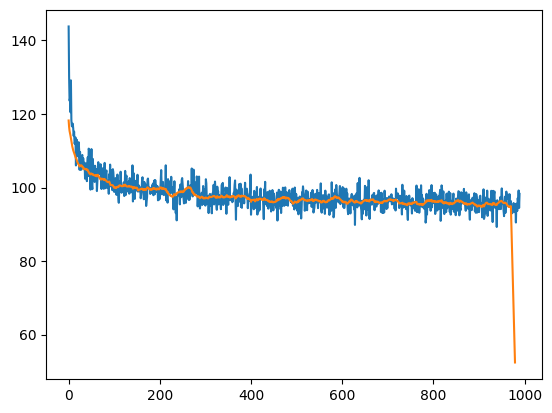